In [16]:
import socket
import argparse
from PIL import Image
import numpy as np
from lib import dwt, ezw, size_amp, huffman, enc_dec
import sys # For sys.exit
import matplotlib.pyplot as plt

In [17]:
def imageDecode_socket(received_combined_data_str, original_image_path_for_psnr):
    
    img_orig = Image.open(original_image_path_for_psnr).convert('L')
    img_orig_array = np.array(img_orig)
    height, width = img_orig_array.shape
    if height != 512 or width != 512: # Assuming 512x512 for reconstruction consistency
        print(f"Warning: Original image size is {width}x{height}. Reconstruction is based on 512x512 processing. PSNR might be affected if dimensions mismatch significantly with encoding assumptions.")
        img_orig = img_orig.resize((512, 512), Image.LANCZOS)   
        img_orig_array = np.array(img_orig) 
   
    # Define the number of bits for the length prefix, must match encoder
    LENGTH_PREFIX_BITS = 32
    current_pos = 0
    segments = []

    try:
        # Expected number of segments
        num_expected_segments = 6 
        for _ in range(num_expected_segments):
            if current_pos + LENGTH_PREFIX_BITS > len(received_combined_data_str):
                print(f"Error: Not enough data to read length prefix. Current position: {current_pos}, Data length: {len(received_combined_data_str)}")
                return -1, None
            
            # Read the length prefix for the current segment
            length_prefix_str = received_combined_data_str[current_pos : current_pos + LENGTH_PREFIX_BITS]
            current_pos += LENGTH_PREFIX_BITS
            segment_length = int(length_prefix_str, 2)

            if current_pos + segment_length > len(received_combined_data_str):
                print(f"Error: Not enough data to read segment. Expected length: {segment_length}, Remaining data: {len(received_combined_data_str) - current_pos}")
                return -1, None

            # Read the segment data
            segment_data = received_combined_data_str[current_pos : current_pos + segment_length]
            segments.append(segment_data)
            current_pos += segment_length

        if len(segments) != num_expected_segments:
            print(f"Error: Data parsing failed. Expected {num_expected_segments} segments, got {len(segments)}")
            return -1, None
        
        code_table_binary, quant_step_binary, \
        recon_huffman_encoded_result_size, recon_encoded_data_lf, \
        recon_huffman_encoded_rs_16_16, recon_ra_16_16_str = segments

    except ValueError as e:
        print(f"Error converting length prefix to int or other value error: {e}")
        return -1, None
    except Exception as e:
        print(f"Error parsing received data with length prefixes: {e}")
        return -1, None

    code_table = enc_dec.convert_binary_to_code_table(code_table_binary)
    quant_step_val = enc_dec.binary_str_to_float(quant_step_binary)


    recon_result_size = enc_dec.decode_data_with_huffman(recon_huffman_encoded_result_size, code_table)
    recon_result_amplitude_str_lf = enc_dec.decode_data_plain(recon_encoded_data_lf)
    recon_rs_16_16 = enc_dec.decode_data_with_huffman(recon_huffman_encoded_rs_16_16, code_table)
    recon_ra_16_16_str = enc_dec.decode_data_plain(recon_ra_16_16_str)
    recon_dpr_list = size_amp.size_amplitude_to_2D_list_optimized(recon_result_size, recon_result_amplitude_str_lf)

    # Assuming reconstruction target size is 512x512 based on encoding process
    recon_img_base_size_h, recon_img_base_size_w = 512, 512
    recon_img = np.zeros((recon_img_base_size_h, recon_img_base_size_w)).astype('float64')
    
    recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            child_1 = ezw.build_tree(recon_img, 1, (i,j+16), 1, None)
            child_3 = ezw.build_tree(recon_img, 1, (i+16,j), 3, None)
            child_4 = ezw.build_tree(recon_img, 1, (i+16,j+16), 4, None)
            recon_root_nodes[i][j] = ezw.EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
            if child_1: child_1.parent = recon_root_nodes[i][j] # type: ignore
            if child_3: child_3.parent = recon_root_nodes[i][j] # type: ignore
            if child_4: child_4.parent = recon_root_nodes[i][j] # type: ignore

    recon_img = ezw.dec_dp_sp(recon_dpr_list, recon_root_nodes, recon_img)
    recon_top_16_16_diff_list = size_amp.size_amplitude_to_2D_list(recon_rs_16_16, recon_ra_16_16_str)
    if not recon_top_16_16_diff_list or not recon_top_16_16_diff_list[0]:
        print("Error: Failed to decode top 16x16 differential data.")
        return -1, None
    recon_top_16_16_diff = recon_top_16_16_diff_list[0][0]


    recon_top_16_16 = np.zeros(256).astype('int')
    if not recon_top_16_16_diff: # Check if list is empty
        print("Error: Decoded top_16_16_diff is empty.")
        return -1, None
    recon_top_16_16[0] = recon_top_16_16_diff[0]
    for i in range(1, min(256, len(recon_top_16_16_diff))): # Ensure we don't go out of bounds
        recon_top_16_16[i] = recon_top_16_16[i-1] + recon_top_16_16_diff[i]
    
    # Fill remaining if recon_top_16_16_diff was shorter than 256
    for i in range(len(recon_top_16_16_diff), 256):
        if i > 0:
            recon_top_16_16[i] = recon_top_16_16[i-1] # Or handle as error/default

    recon_top_16_16 = recon_top_16_16.reshape((16,16))
    recon_img[0:16, 0:16] = recon_top_16_16
    recon_img_after_quant = recon_img * quant_step_val
    l5_recon_img_after_quant = dwt.reconstruction_from_specify_level(recon_img_after_quant, 5)
    
    # Clip values to [0, 255] and ensure correct data type for image saving and PSNR
    l5_recon_img_final = np.clip(l5_recon_img_after_quant, 0, 255)

  
    # Calculate PSNR against the relevant part of original if shapes differ, or against full if they match.
    # Assuming we compare with the original image array directly.
    mse = np.mean((l5_recon_img_final.astype(np.float64) - img_orig_array) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 10 * np.log10(255**2 / mse)
    return psnr, l5_recon_img_final.astype(np.uint8)




Decoder: Attempting to listen on 10.16.15.133:65432...
Decoder: Listening on 10.16.15.133:65432...
Decoder: Connected by ('10.32.178.233', 57048)
Decoder: Expecting 140872 bits of image data.
Decoder: Received 17609 bytes of image data.
Decoder: Image data received. Starting decode...
Decoding complete. PSNR: 26.87 dB


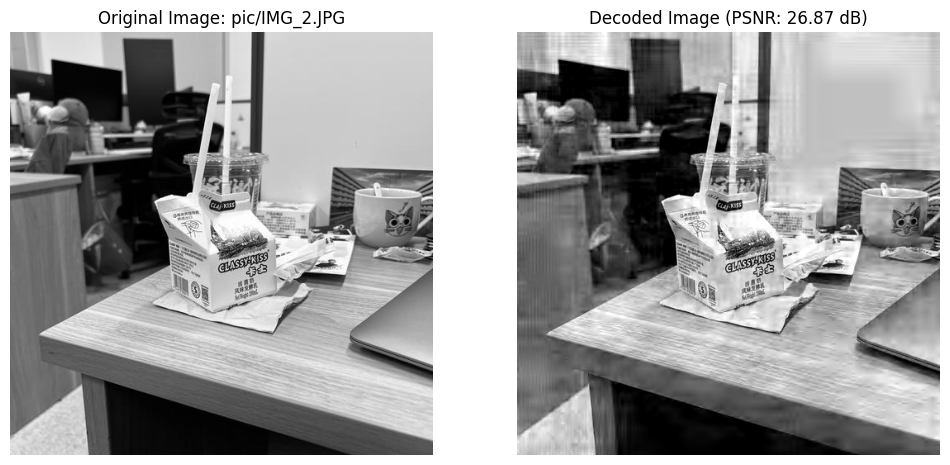

Decoded image saved to decoded_image_from_socket.png


In [18]:
original_image_path_param = "pic/IMG_2.JPG"  # 用于PSNR计算的原始图像路径
host_param = "10.16.15.133"                # 监听的主机名或IP地址
port_param = 65432                      # 监听的端口号
output_path_param = "decoded_image_from_socket.png" # 解码后图像的保存路径

# 确保 imageDecode_socket 函数已在前面的单元格中定义

print(f"Decoder: Attempting to listen on {host_param}:{port_param}...")


with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        # Allow address reuse
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((host_param, port_param))
    s.listen()
    print(f"Decoder: Listening on {host_param}:{port_param}...")
        
        # This will block until a connection is made.
        # If running in a notebook, this cell will appear "busy" until a connection.
    conn, addr = s.accept()
        
    with conn:
        print(f"Decoder: Connected by {addr}")
            
            # Receive original length of the binary string
        original_length_bytes = conn.recv(8) # 8 bytes for unsigned long long
        if not original_length_bytes or len(original_length_bytes) < 8:
            print("Decoder: Did not receive complete length information. Closing connection.")
                # sys.exit(1) # In a notebook, just print and let cell finish or raise error
            raise ConnectionAbortedError("Did not receive complete length information.")

        original_length = int.from_bytes(original_length_bytes, 'big')
        print(f"Decoder: Expecting {original_length} bits of image data.")

        received_bytes = bytearray()
        total_bytes_to_receive = (original_length + 7) // 8 
            
        bytes_received_count = 0
        while bytes_received_count < total_bytes_to_receive:
            chunk_size = min(4096, total_bytes_to_receive - bytes_received_count)
            chunk = conn.recv(chunk_size)
            if not chunk:
                print("Decoder: Connection broken while receiving image data.")
                    # sys.exit(1)
                raise ConnectionAbortedError("Connection broken while receiving image data.")
            received_bytes.extend(chunk)
            bytes_received_count += len(chunk)
            
        print(f"Decoder: Received {len(received_bytes)} bytes of image data.")

        binary_string_from_bytes = ''.join(format(byte, '08b') for byte in received_bytes)
        received_combined_data_str = binary_string_from_bytes[:original_length]

        if len(received_combined_data_str) != original_length:
            print(f"Error: Data integrity issue. Expected {original_length} bits, got {len(received_combined_data_str)} after conversion.")
                # sys.exit(1)
            raise ValueError("Data integrity issue during reception.")

        print("Decoder: Image data received. Starting decode...")
            
            # 确保 imageDecode_socket 函数已定义
        psnr, decoded_image_array = imageDecode_socket(received_combined_data_str, original_image_path_param)

        if decoded_image_array is not None:
            print(f"Decoding complete. PSNR: {psnr:.2f} dB")
            decoded_image = Image.fromarray(decoded_image_array)
            
            # Load the original image for display
            original_image_display = Image.open(original_image_path_param).convert('L') # Convert to L for consistency if needed
            if original_image_display.size != (512,512) and decoded_image.size == (512,512):
                # If original was not 512x512 but decoder output is, resize original for fair visual comparison
                original_image_display = original_image_display.resize((512, 512), Image.Resampling.LANCZOS)

            # Display both images for comparison
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            
            axes[0].imshow(original_image_display, cmap='gray')
            axes[0].set_title(f"Original Image: {original_image_path_param}")
            axes[0].axis('off')
            
            axes[1].imshow(decoded_image, cmap='gray')
            axes[1].set_title(f"Decoded Image (PSNR: {psnr:.2f} dB)")
            axes[1].axis('off')
            
            plt.show()
            
            decoded_image.save(output_path_param)
            print(f"Decoded image saved to {output_path_param}")
        else:
            print("Decoding failed.")